# Kiểm tra lại dataset pre processed

In [1]:
!ls /kaggle/input/tt100k_crops

class_counts.csv   idx2label.json  test
dataset_stats.npz  label2idx.json  train


![Traffic sign categories – TT100K dataset](https://cg.cs.tsinghua.edu.cn/traffic-sign/images/index/u16.jpg)


In [2]:
import os, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = "/kaggle/input/tt100k_crops"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# === Kiểm tra GPU ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Device: {device.upper()}")

# 📊 Load mean/std
stats = np.load(os.path.join(DATA_DIR, "dataset_stats.npz"))
mean, std = stats["mean"], stats["std"]
print(f"✅ Mean: {mean}")
print(f"✅ Std : {std}")

# 📁 Load label mapping
with open(os.path.join(DATA_DIR, "idx2label.json"), "r") as f:
    idx2label = json.load(f)

num_classes = len(idx2label)
print(f"📦 Tổng số class: {num_classes}")


🚀 Device: CUDA
✅ Mean: [0.25624022 0.25624022 0.25624022]
✅ Std : [0.2828717  0.2483278  0.27525714]
📦 Tổng số class: 91


In [4]:
# ĐẾM SỐ ẢNH MỖI CLASS
def count_images(folder):
    data = []
    for cls in sorted(os.listdir(folder)):
        cls_path = os.path.join(folder, cls)
        if not os.path.isdir(cls_path): continue
        n = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png'))])
        data.append((cls, n))
    return pd.DataFrame(data, columns=["class", "count"]).sort_values("count", ascending=False)

df_train = count_images(TRAIN_DIR)
df_test  = count_images(TEST_DIR)

print(f"📊 Train: {df_train['count'].sum()} ảnh, {len(df_train)} class")
print(f"📊 Test  : {df_test['count'].sum()} ảnh, {len(df_test)} class")


📊 Train: 15985 ảnh, 91 class
📊 Test  : 9226 ảnh, 91 class


In [5]:
# # HIỂN THỊ ẢNH NGẪU NHIÊN
# import random

# sample_tfms = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
# dataset_preview = datasets.ImageFolder(TRAIN_DIR, transform=sample_tfms)

# fig, axes = plt.subplots(2, 5, figsize=(12,5))
# for ax in axes.flat:
#     img_idx = random.randint(0, len(dataset_preview)-1)
#     img, label = dataset_preview[img_idx]
#     img = img.permute(1,2,0)
#     label_name = dataset_preview.classes[label]
#     ax.imshow(img)
#     ax.set_title(f"{label_name} ({label})")
#     ax.axis("off")

# plt.suptitle("Ảnh ngẫu nhiên từ tập Train", fontsize=14)
# plt.tight_layout()
# plt.show()


# Training các model

## Bước 1: Build Transform & Augmentation Pipeline
Khởi tạo transform pipeline để xử lý ảnh trước khi training.

In [6]:
# HÀM TẠO TRANSFORM
from torchvision import transforms

def build_transforms(mean, std, img_size=64):
    """
    Trả về 2 transforms:
      - train_transform: có augment
      - test_transform : chỉ normalize
    """
    train_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    test_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    return train_tfms, test_tfms

# === Khởi tạo thử ===
stats = np.load("/kaggle/input/tt100k_crops/dataset_stats.npz")
mean, std = stats["mean"], stats["std"]
train_tfms, test_tfms = build_transforms(mean, std, img_size=64)

print("✅ Đã tạo transform cho train & test thành công!")


✅ Đã tạo transform cho train & test thành công!


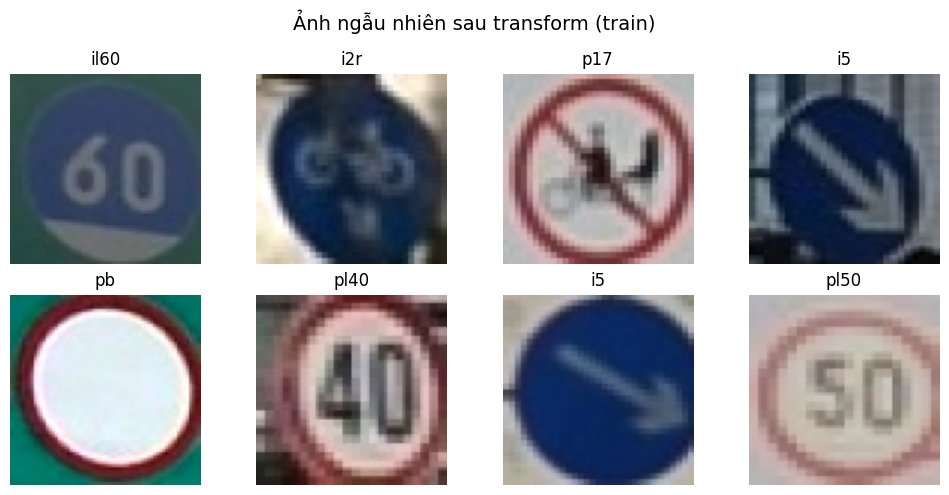

In [7]:
# STEP 1.2 – KIỂM TRA ẢNH SAU TRANSFORM
from torchvision import datasets
import matplotlib.pyplot as plt
import torch

DATA_DIR = "/kaggle/input/tt100k_crops"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

dataset_preview = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)

# Lấy 8 ảnh ngẫu nhiên
fig, axes = plt.subplots(2, 4, figsize=(10,5))
for ax in axes.flat:
    idx = torch.randint(0, len(dataset_preview), (1,)).item()
    img, label = dataset_preview[idx]
    img = img.permute(1, 2, 0)  # đổi CHW → HWC
    label_name = dataset_preview.classes[label]
    ax.imshow(torch.clamp(img * std + mean, 0, 1))  # khử normalize để xem
    ax.set_title(f"{label_name}")
    ax.axis("off")

plt.suptitle("Ảnh ngẫu nhiên sau transform (train)", fontsize=14)
plt.tight_layout()
plt.show()


## Bước 2: Tạo DataLoader cho train/test.
Mục tiêu của bước này là biến transform pipeline (Bước 1) thành luồng dữ liệu thật sự sẵn sàng để huấn luyện. Và kết hợp thêm kĩ thuật Mixup & Cutmix để tăng tính tổng quát hóa của mô hình và tránh overfitting

In [8]:
# 🧩 STEP 2.1 – HÀM MIXUP & CUTMIX COLLATE
import torch
import random
import numpy as np

def mixup_data(x, y, alpha=0.2):
    """MixUp – trộn ảnh nhẹ"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def cutmix_data(x, y, alpha=0.5):
    """CutMix – pha trộn nhẹ, giữ lại form chính"""
    lam = np.random.beta(alpha, alpha)
    batch_size, _, h, w = x.size()
    index = torch.randperm(batch_size).to(x.device)

    # random box nhỏ (chỉ 20–40% diện tích)
    cut_rat = np.sqrt(1. - lam)
    cut_rat = np.clip(cut_rat, 0.2, 0.4)
    cut_w, cut_h = int(w * cut_rat), int(h * cut_rat)

    cx, cy = np.random.randint(w), np.random.randint(h)
    x1, y1 = np.clip(cx - cut_w // 2, 0, w), np.clip(cy - cut_h // 2, 0, h)
    x2, y2 = np.clip(cx + cut_w // 2, 0, w), np.clip(cy + cut_h // 2, 0, h)

    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (w * h))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam


def mixup_cutmix_collate_fn(batch, mixup_alpha=0.2, cutmix_alpha=0.5, p=0.4):
    """
    Collate function MixUp/CutMix nhẹ tay:
    - p=0.4: chỉ 40% batch được áp dụng augment
    - 20% MixUp, 20% CutMix
    - 60% còn lại giữ ảnh gốc
    """
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs)
    labels = torch.tensor(labels)

    rand = random.random()
    if rand < p / 2:  # 20%
        imgs, y_a, y_b, lam = mixup_data(imgs, labels, alpha=mixup_alpha)
        return imgs, (y_a, y_b, lam, "mixup")
    elif rand < p:  # 20%
        imgs, y_a, y_b, lam = cutmix_data(imgs, labels, alpha=cutmix_alpha)
        return imgs, (y_a, y_b, lam, "cutmix")
    else:
        return imgs, (labels, labels, 1.0, "none")

In [9]:
# 🧩 STEP 2.2 – Kết hợp vào DataLoader
from torch.utils.data import DataLoader
from torchvision import datasets

def load_dataloaders(train_dir, test_dir, train_tfms, test_tfms, batch_size=64):
    """
    Trả về:
      - train_loader (có MixUp/CutMix)
      - test_loader  (bình thường)
      - train_dataset (để truy cập class_to_idx)
    """
    train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
    test_ds  = datasets.ImageFolder(test_dir,  transform=test_tfms)

    # Train loader với MixUp + CutMix
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        collate_fn=lambda b: mixup_cutmix_collate_fn(
            b,
            mixup_alpha=0.4,   # mức trộn nhẹ vừa phải
            cutmix_alpha=1.0,  # vùng cắt lớn hơn
            p=0.7              # 70% batch sẽ bị trộn
        )
    )

    # Test loader chuẩn
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"✅ Train set: {len(train_ds)} ảnh | {len(train_ds.classes)} class")
    print(f"✅ Test  set: {len(test_ds)} ảnh  | {len(test_ds.classes)} class")
    print(f"📦 Batch size: {batch_size}")
    print(f"🔁 Tổng batch train: {len(train_loader)}, test: {len(test_loader)}")

    return train_loader, test_loader, train_ds

In [10]:
# 🧩 STEP 2.4 – KHỞI TẠO DATALOADER THỰC TẾ
DATA_DIR = "/kaggle/input/tt100k_crops"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

train_loader, test_loader, train_ds = load_dataloaders(
    TRAIN_DIR,
    TEST_DIR,
    train_tfms,  # từ STEP 1
    test_tfms,
    batch_size=64
)

num_classes = len(train_ds.classes)
print(f"🔢 Tổng số class: {num_classes}")

✅ Train set: 15985 ảnh | 91 class
✅ Test  set: 9226 ảnh  | 91 class
📦 Batch size: 64
🔁 Tổng batch train: 250, test: 145
🔢 Tổng số class: 91


## Bước 3: Xây dựng model linh hoạt (multi-backbone).
Đây là phần quan trọng nhất của pipeline vì nó quyết định khả năng tái sử dụng:
cậu chỉ cần thay tên "resnet18", "mobilenetv2", "efficientnetb0" hoặc "shufflenetv2" là có thể train được model mới, mà không đụng lại code huấn luyện.

In [11]:
# STEP 3.1 – HÀM KHỞI TẠO MODEL LINH HOẠT
from torchvision import models
import torch.nn as nn

def build_model(model_name, num_classes, pretrained=True, freeze_backbone=False):
    """
    Trả về model theo tên model_name.
    Hỗ trợ:
        - resnet18|
        - mobilenetv2
        - efficientnetb0
        - shufflenetv2_x0_5
        - shufflenetv2_x1_0
    """

    model_name = model_name.lower()
    if model_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)

    elif model_name == "mobilenetv2":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1" if pretrained else None)
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)

    elif model_name == "efficientnetb0":
        model = models.efficientnet_b0(weights="IMAGENET1K_V1" if pretrained else None)
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)

    elif model_name == "shufflenetv2_x0_5":
        model = models.shufflenet_v2_x0_5(weights="IMAGENET1K_V1" if pretrained else None)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)

    elif model_name == "shufflenetv2_x1_0":
        model = models.shufflenet_v2_x1_0(weights="IMAGENET1K_V1" if pretrained else None)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)

    else:
        raise ValueError(f"❌ Model '{model_name}' không được hỗ trợ!")

    # Freeze backbone nếu cần
    if freeze_backbone:
        for name, param in model.named_parameters():
            if "fc" not in name and "classifier" not in name:
                param.requires_grad = False

    return model


In [12]:
# STEP 3.2 – KIỂM TRA MODEL
num_classes = len(train_ds.classes)
device = "cuda" if torch.cuda.is_available() else "cpu"

for name in ["resnet18", "mobilenetv2", "efficientnetb0", "shufflenetv2_x0_5", "shufflenetv2_x1_0"]:
    model = build_model(name, num_classes, pretrained=True).to(device)
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ {name.upper():18} | Parameters: {n_params/1e6:.2f}M | Output: {num_classes}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


✅ RESNET18           | Parameters: 11.22M | Output: 91


100%|██████████| 13.6M/13.6M [00:00<00:00, 65.5MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


✅ MOBILENETV2        | Parameters: 2.34M | Output: 91


100%|██████████| 20.5M/20.5M [00:00<00:00, 180MB/s]
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


✅ EFFICIENTNETB0     | Parameters: 4.12M | Output: 91


100%|██████████| 5.28M/5.28M [00:00<00:00, 12.2MB/s]
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


✅ SHUFFLENETV2_X0_5  | Parameters: 0.44M | Output: 91


100%|██████████| 8.79M/8.79M [00:00<00:00, 120MB/s]

✅ SHUFFLENETV2_X1_0  | Parameters: 1.35M | Output: 91


## Bước 4: Định nghĩa Loss, Optimizer, và Scheduler.

In [13]:
# STEP 4.1 – HÀM TẠO LOSS, OPTIMIZER, SCHEDULER
import torch.optim as optim

def build_training_components(model, lr=1e-3, weight_decay=1e-4, scheduler_type="cosine", freeze_backbone=False):
    """
    Trả về tuple: (criterion, optimizer, scheduler)
    scheduler_type: 'cosine', 'step', 'none'
    """
    # === Freeze backbone nếu cần ===
    if freeze_backbone:
        for name, param in model.named_parameters():
            if "fc" not in name and "classifier" not in name:
                param.requires_grad = False

    # === Loss function ===
    criterion = nn.CrossEntropyLoss()

    # === Optimizer ===
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    # === Scheduler ===
    if scheduler_type == "cosine":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    elif scheduler_type == "step":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    else:
        scheduler = None

    return criterion, optimizer, scheduler


## Bước 5: Training Loop hoàn chỉnh

In [14]:
# STEP 5.1 – HÀM TÍNH METRIC
from sklearn.metrics import precision_score, recall_score, f1_score, top_k_accuracy_score
import torch

def compute_metrics(y_true, y_pred, num_classes):
    """
    y_true, y_pred là tensor hoặc list các label
    """
    y_true = torch.tensor(y_true).cpu().numpy()
    y_pred = torch.tensor(y_pred).cpu().numpy()
    
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return precision, recall, f1


In [15]:
# STEP 5.2 – HÀM TRAIN & EVALUATE
import time
import torch

def train_one_epoch(model, loader, optimizer, criterion, device, grad_clip=1.0):
    model.train()
    total_loss, correct, total = 0, 0, 0
    preds_all, labels_all = [], []
    start = time.time()

    for imgs, targets in loader:
        imgs = imgs.to(device)
        y_a, y_b, lam, mode = targets
        y_a, y_b = y_a.to(device), y_b.to(device)
        optimizer.zero_grad()

        preds = model(imgs)

        # === Tính loss theo chế độ MixUp / CutMix ===
        if mode in ["mixup", "cutmix"]:
            loss = lam * criterion(preds, y_a) + (1 - lam) * criterion(preds, y_b)
        else:
            loss = criterion(preds, y_a)

        loss.backward()

        # Gradient clipping – tránh bùng gradient
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds_all.extend(preds.argmax(1).cpu().tolist())
        labels_all.extend(y_a.cpu().tolist())  # y_a chính là label gốc
        correct += (preds.argmax(1) == y_a).sum().item()
        total += y_a.size(0)

    epoch_time = time.time() - start
    precision, recall, f1 = compute_metrics(labels_all, preds_all, num_classes=len(set(labels_all)))
    acc = correct / total
    avg_loss = total_loss / total
    return avg_loss, acc, precision, recall, f1, epoch_time


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds_all, labels_all = [], []
    total_infer_time, total_images = 0.0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            start = time.time()
            preds = model(imgs)
            infer_time = time.time() - start
            total_infer_time += infer_time
            total_images += imgs.size(0)

            loss = criterion(preds, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)
            preds_all.extend(preds.argmax(1).cpu().tolist())
            labels_all.extend(labels.cpu().tolist())

    precision, recall, f1 = compute_metrics(labels_all, preds_all, num_classes=len(set(labels_all)))
    acc = correct / total
    avg_loss = total_loss / total
    fps = total_images / total_infer_time if total_infer_time > 0 else 0
    return avg_loss, acc, precision, recall, f1, fps
    

In [16]:
# 🧩 STEP 5.3 – HÀM TRAIN MODEL HOÀN CHỈNH 
import pandas as pd
import matplotlib.pyplot as plt
import time, torch

def train_model(model_name, model, criterion, optimizer, scheduler, train_loader, test_loader, device,
                epochs=30, patience=5, grad_clip=1.0):
    log = []
    best_val_acc, best_val_loss = 0, float('inf')
    best_model_path = f"/kaggle/working/{model_name}_best.pth"
    patience_counter = 0

    print(f"🚀 Bắt đầu training model {model_name} ({epochs} epochs)")
    start_all = time.time()   # <--- Bắt đầu đo tổng thời gian

    for epoch in range(1, epochs + 1):
        # --- TRAIN ---
        train_loss, train_acc, train_prec, train_rec, train_f1, t_time = train_one_epoch(
            model, train_loader, optimizer, criterion, device, grad_clip
        )

        # --- VALIDATE ---
        val_loss, val_acc, val_prec, val_rec, val_f1, fps = evaluate(
            model, test_loader, criterion, device
        )

        # --- Scheduler update ---
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # --- Log ---
        log.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "precision": val_prec,
            "recall": val_rec,
            "f1": val_f1,
            "train_time": t_time,
            "fps": fps
        })

        print(f"📘 Epoch {epoch:02d}/{epochs} | "
              f"TrainAcc: {train_acc:.4f} | ValAcc: {val_acc:.4f} | "
              f"F1: {val_f1:.4f} | FPS: {fps:.1f} | "
              f"TrainTime: {t_time:.1f}s")

        # --- Checkpoint ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1

        # --- Early Stopping ---
        if patience_counter >= patience:
            print(f"⛔ Early stopping at epoch {epoch} (no improvement in {patience} epochs)")
            break

    # --- Tổng thời gian ---
    total_time = time.time() - start_all
    avg_epoch_time = total_time / len(log)
    print(f"⏱️ Tổng thời gian training: {total_time:.1f}s (~{avg_epoch_time:.1f}s / epoch)")

    # === SAVE LOG ===
    df_log = pd.DataFrame(log)
    df_log["total_time_s"] = total_time
    df_log["avg_epoch_time_s"] = avg_epoch_time
    df_log.to_csv(f"/kaggle/working/{model_name}_train_log.csv", index=False)
    print(f"💾 Log saved to {model_name}_train_log.csv")
    print(f"🏆 Best model saved ({best_val_acc:.3f}) → {best_model_path}")

    # === Plot loss/acc/FPS ===
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(df_log["epoch"], df_log["train_loss"], label="Train Loss")
    axes[0].plot(df_log["epoch"], df_log["val_loss"], label="Val Loss")
    axes[0].set_title("Loss over Epochs"); axes[0].legend()

    axes[1].plot(df_log["epoch"], df_log["train_acc"], label="Train Acc")
    axes[1].plot(df_log["epoch"], df_log["val_acc"], label="Val Acc")
    axes[1].set_title("Accuracy over Epochs"); axes[1].legend()

    axes[2].plot(df_log["epoch"], df_log["fps"], label="FPS", color="green")
    axes[2].set_title("Throughput (FPS)"); axes[2].legend()

    plt.tight_layout()
    plt.show()

    return df_log


## Bước 6: Train từng model riêng biệt & lưu kết quả tổng hợp

### Train ResNet18

🚀 Bắt đầu training model resnet18 (30 epochs)
📘 Epoch 01/30 | TrainAcc: 0.6553 | ValAcc: 0.8716 | F1: 0.6129 | FPS: 16456.9 | TrainTime: 29.5s
📘 Epoch 02/30 | TrainAcc: 0.7453 | ValAcc: 0.9090 | F1: 0.7056 | FPS: 14356.1 | TrainTime: 13.8s
📘 Epoch 03/30 | TrainAcc: 0.7810 | ValAcc: 0.9539 | F1: 0.8480 | FPS: 16370.8 | TrainTime: 14.1s
📘 Epoch 04/30 | TrainAcc: 0.7402 | ValAcc: 0.9657 | F1: 0.9004 | FPS: 16429.5 | TrainTime: 13.9s
📘 Epoch 05/30 | TrainAcc: 0.7800 | ValAcc: 0.9702 | F1: 0.9217 | FPS: 14431.5 | TrainTime: 14.0s
📘 Epoch 06/30 | TrainAcc: 0.8179 | ValAcc: 0.9803 | F1: 0.9411 | FPS: 15287.0 | TrainTime: 14.3s
📘 Epoch 07/30 | TrainAcc: 0.8021 | ValAcc: 0.9822 | F1: 0.9591 | FPS: 16468.7 | TrainTime: 14.1s
📘 Epoch 08/30 | TrainAcc: 0.8098 | ValAcc: 0.9843 | F1: 0.9642 | FPS: 15250.5 | TrainTime: 13.9s
📘 Epoch 09/30 | TrainAcc: 0.8308 | ValAcc: 0.9854 | F1: 0.9665 | FPS: 15725.7 | TrainTime: 14.4s
📘 Epoch 10/30 | TrainAcc: 0.8742 | ValAcc: 0.9868 | F1: 0.9692 | FPS: 15222.7 | T

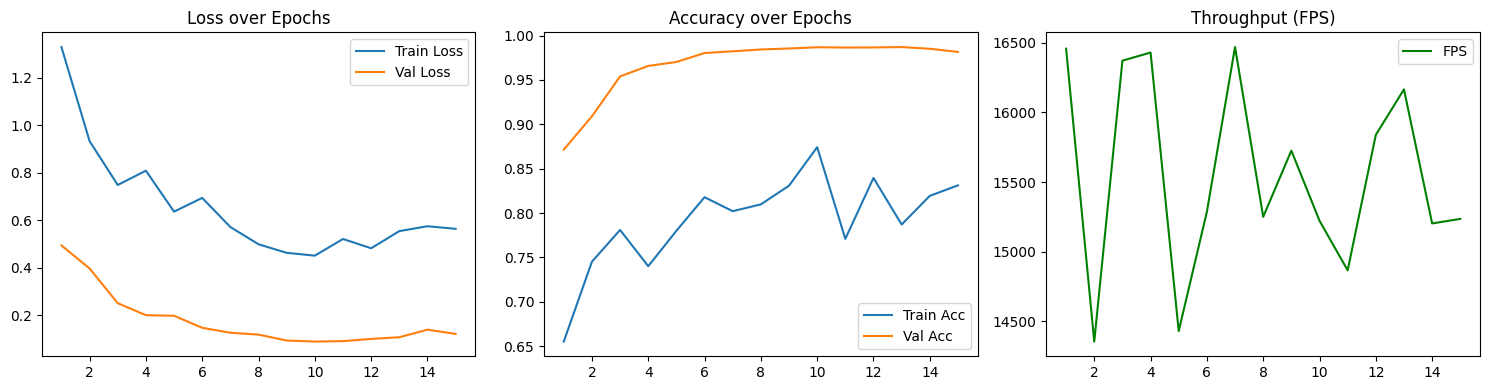

In [17]:
# STEP 6.1 – TRAIN RESNET18
model_name = "resnet18"
model = build_model(model_name, len(train_ds.classes), pretrained=True).to(device)
criterion, optimizer, scheduler = build_training_components(model, lr=1e-3, scheduler_type="cosine")

log_resnet = train_model(model_name, model, criterion, optimizer, scheduler,
                         train_loader, test_loader, device, epochs=30)


### Train MobileNetV2

🚀 Bắt đầu training model mobilenetv2 (30 epochs)
📘 Epoch 01/30 | TrainAcc: 0.6198 | ValAcc: 0.8815 | F1: 0.6203 | FPS: 7116.4 | TrainTime: 14.3s
📘 Epoch 02/30 | TrainAcc: 0.7506 | ValAcc: 0.9356 | F1: 0.7935 | FPS: 7365.8 | TrainTime: 14.2s
📘 Epoch 03/30 | TrainAcc: 0.7708 | ValAcc: 0.9602 | F1: 0.8795 | FPS: 7362.7 | TrainTime: 14.9s
📘 Epoch 04/30 | TrainAcc: 0.7984 | ValAcc: 0.9599 | F1: 0.8939 | FPS: 7621.9 | TrainTime: 14.4s
📘 Epoch 05/30 | TrainAcc: 0.7952 | ValAcc: 0.9750 | F1: 0.9273 | FPS: 6636.8 | TrainTime: 14.2s
📘 Epoch 06/30 | TrainAcc: 0.8003 | ValAcc: 0.9841 | F1: 0.9605 | FPS: 7482.1 | TrainTime: 14.8s
📘 Epoch 07/30 | TrainAcc: 0.8265 | ValAcc: 0.9872 | F1: 0.9661 | FPS: 7076.8 | TrainTime: 14.4s
📘 Epoch 08/30 | TrainAcc: 0.8073 | ValAcc: 0.9871 | F1: 0.9706 | FPS: 7275.0 | TrainTime: 14.7s
📘 Epoch 09/30 | TrainAcc: 0.8383 | ValAcc: 0.9874 | F1: 0.9712 | FPS: 7132.2 | TrainTime: 15.1s
📘 Epoch 10/30 | TrainAcc: 0.7434 | ValAcc: 0.9883 | F1: 0.9735 | FPS: 7221.5 | TrainTim

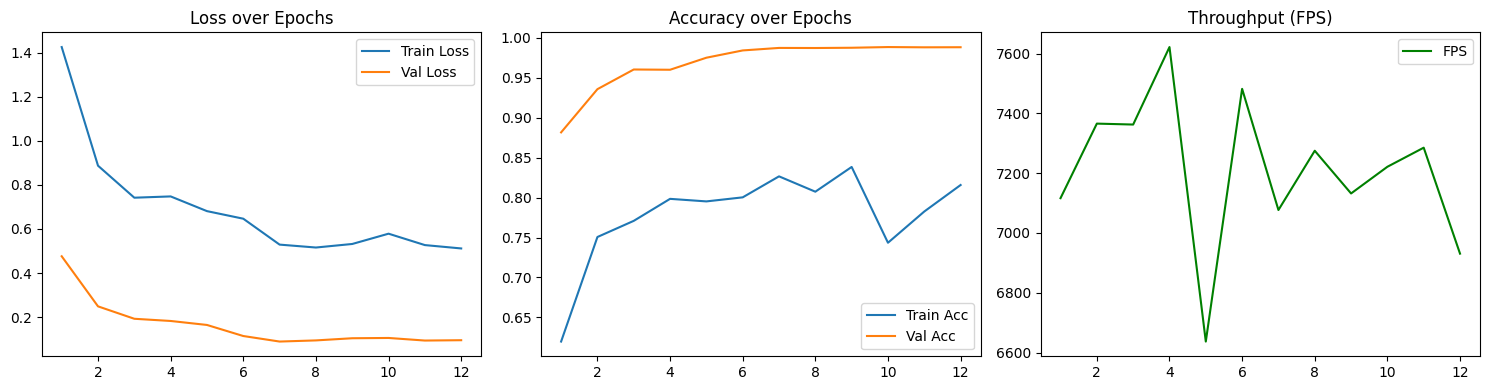

In [18]:
# STEP 6.2 – TRAIN MOBILENETV2
model_name = "mobilenetv2"
model = build_model(model_name, len(train_ds.classes), pretrained=True).to(device)
criterion, optimizer, scheduler = build_training_components(model, lr=1e-3, scheduler_type="cosine")

log_mobilenet = train_model(model_name, model, criterion, optimizer, scheduler,
                            train_loader, test_loader, device, epochs=30)


### Train EfficientNetB0

🚀 Bắt đầu training model efficientnetb0 (30 epochs)
📘 Epoch 01/30 | TrainAcc: 0.5811 | ValAcc: 0.9029 | F1: 0.7130 | FPS: 4617.2 | TrainTime: 14.9s
📘 Epoch 02/30 | TrainAcc: 0.7666 | ValAcc: 0.9597 | F1: 0.8784 | FPS: 4678.8 | TrainTime: 14.9s
📘 Epoch 03/30 | TrainAcc: 0.7715 | ValAcc: 0.9660 | F1: 0.8960 | FPS: 4952.3 | TrainTime: 15.0s
📘 Epoch 04/30 | TrainAcc: 0.7872 | ValAcc: 0.9734 | F1: 0.9348 | FPS: 4703.4 | TrainTime: 14.8s
📘 Epoch 05/30 | TrainAcc: 0.8190 | ValAcc: 0.9837 | F1: 0.9447 | FPS: 4829.2 | TrainTime: 15.0s
📘 Epoch 06/30 | TrainAcc: 0.8176 | ValAcc: 0.9836 | F1: 0.9588 | FPS: 4819.9 | TrainTime: 15.7s
📘 Epoch 07/30 | TrainAcc: 0.7902 | ValAcc: 0.9841 | F1: 0.9528 | FPS: 4879.1 | TrainTime: 14.7s
📘 Epoch 08/30 | TrainAcc: 0.8458 | ValAcc: 0.9881 | F1: 0.9690 | FPS: 4816.0 | TrainTime: 15.2s
📘 Epoch 09/30 | TrainAcc: 0.8332 | ValAcc: 0.9889 | F1: 0.9724 | FPS: 4697.5 | TrainTime: 15.0s
📘 Epoch 10/30 | TrainAcc: 0.8174 | ValAcc: 0.9886 | F1: 0.9720 | FPS: 4917.4 | Train

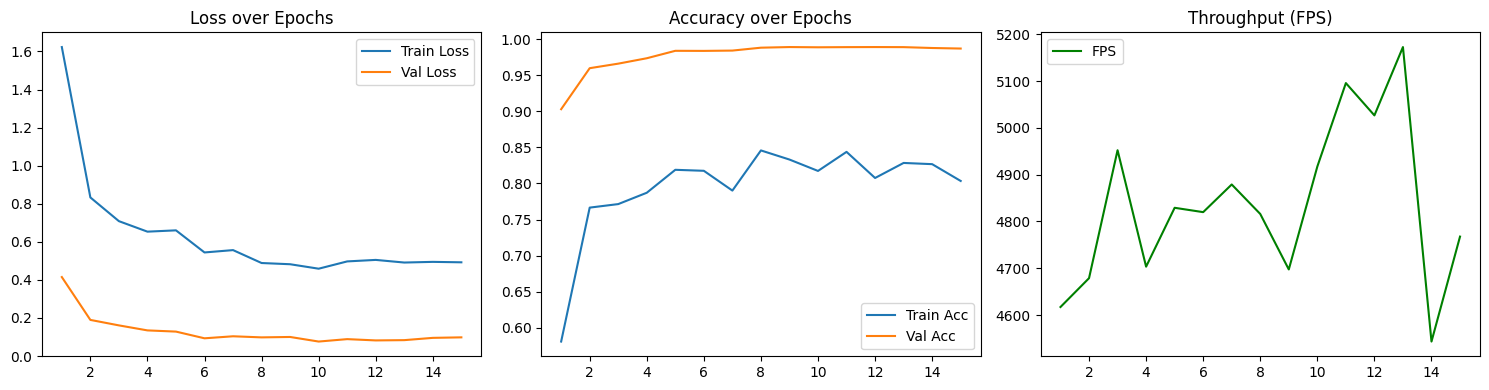

In [19]:
# STEP 6.3 – TRAIN EFFICIENTNETB0
model_name = "efficientnetb0"
model = build_model(model_name, len(train_ds.classes), pretrained=True).to(device)
criterion, optimizer, scheduler = build_training_components(model, lr=1e-3, scheduler_type="cosine")

log_effnet = train_model(model_name, model, criterion, optimizer, scheduler,
                         train_loader, test_loader, device, epochs=30)


### Train ShuffleNetV2 x1.0

🚀 Bắt đầu training model shufflenetv2_x1_0 (30 epochs)
📘 Epoch 01/30 | TrainAcc: 0.4972 | ValAcc: 0.8134 | F1: 0.3677 | FPS: 6000.8 | TrainTime: 14.6s
📘 Epoch 02/30 | TrainAcc: 0.7115 | ValAcc: 0.9062 | F1: 0.6239 | FPS: 5596.4 | TrainTime: 14.7s
📘 Epoch 03/30 | TrainAcc: 0.7749 | ValAcc: 0.9486 | F1: 0.8191 | FPS: 5742.2 | TrainTime: 14.4s
📘 Epoch 04/30 | TrainAcc: 0.8173 | ValAcc: 0.9583 | F1: 0.8722 | FPS: 5952.4 | TrainTime: 14.0s
📘 Epoch 05/30 | TrainAcc: 0.8036 | ValAcc: 0.9687 | F1: 0.8958 | FPS: 5527.8 | TrainTime: 14.0s
📘 Epoch 06/30 | TrainAcc: 0.8213 | ValAcc: 0.9765 | F1: 0.9332 | FPS: 5966.9 | TrainTime: 14.0s
📘 Epoch 07/30 | TrainAcc: 0.8238 | ValAcc: 0.9771 | F1: 0.9390 | FPS: 5684.6 | TrainTime: 14.1s
📘 Epoch 08/30 | TrainAcc: 0.7745 | ValAcc: 0.9806 | F1: 0.9449 | FPS: 5572.8 | TrainTime: 14.4s
📘 Epoch 09/30 | TrainAcc: 0.8221 | ValAcc: 0.9820 | F1: 0.9501 | FPS: 5629.2 | TrainTime: 14.1s
📘 Epoch 10/30 | TrainAcc: 0.8104 | ValAcc: 0.9816 | F1: 0.9461 | FPS: 5809.3 | Tr

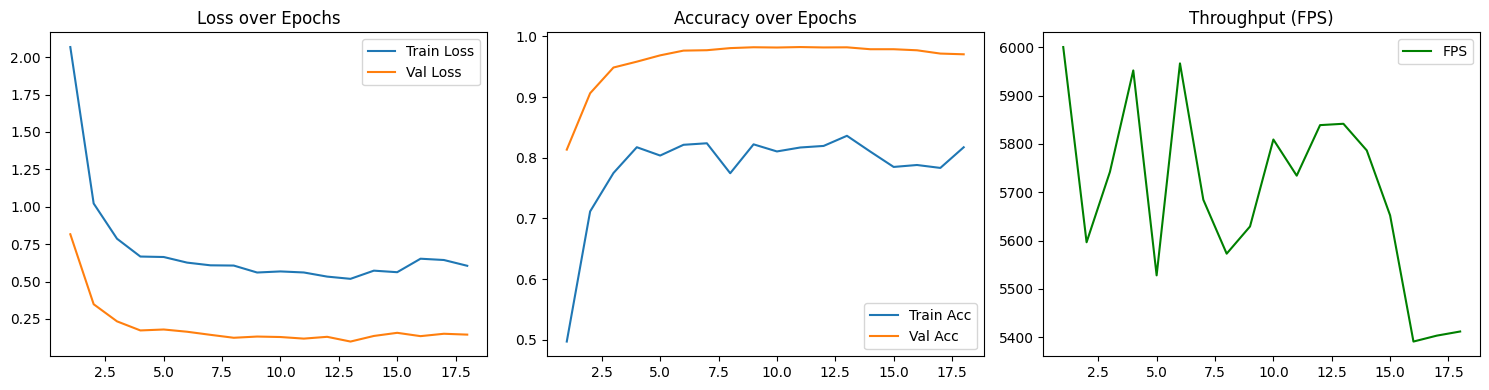

In [20]:
# STEP 6.4 – TRAIN SHUFFLENETV2_X1_0
model_name = "shufflenetv2_x1_0"
model = build_model(model_name, len(train_ds.classes), pretrained=True).to(device)
criterion, optimizer, scheduler = build_training_components(model, lr=1e-3, scheduler_type="cosine")

log_shuffle = train_model(model_name, model, criterion, optimizer, scheduler,
                          train_loader, test_loader, device, epochs=30)


# Tổng hợp kết quả

In [21]:
import pandas as pd

def summarize_results(model_name, df_log):
    # Lấy epoch có val_acc cao nhất
    best_epoch = df_log.loc[df_log["val_acc"].idxmax()]

    # Lấy tổng thời gian (đã lưu sẵn trong log)
    total_time = df_log["total_time_s"].iloc[0] if "total_time_s" in df_log.columns else None
    avg_epoch_time = df_log["avg_epoch_time_s"].iloc[0] if "avg_epoch_time_s" in df_log.columns else None

    return {
        "Model": model_name,
        "Best_Epoch": int(best_epoch["epoch"]),
        "Train_Acc": round(best_epoch["train_acc"], 4),
        "Val_Acc": round(best_epoch["val_acc"], 4),
        "Precision": round(best_epoch["precision"], 4),
        "Recall": round(best_epoch["recall"], 4),
        "F1": round(best_epoch["f1"], 4),
        "FPS": round(best_epoch["fps"], 1) if "fps" in best_epoch else None,
        "Train_Time(s)": round(best_epoch["train_time"], 2),
        "Avg_Epoch_Time(s)": round(avg_epoch_time, 2) if avg_epoch_time else None,
        "Total_Train_Time(s)": round(total_time, 2) if total_time else None
    }

# =========================================================
# 🧩 GỘP KẾT QUẢ CỦA 4 MODEL
# =========================================================
results = [
    summarize_results("ResNet18", log_resnet),
    summarize_results("MobileNetV2", log_mobilenet),
    summarize_results("EfficientNetB0", log_effnet),
    summarize_results("ShuffleNetV2_x1.0", log_shuffle)
]

df_summary = pd.DataFrame(results)

# Sắp xếp theo Val_Acc giảm dần
df_summary = df_summary.sort_values(by="Val_Acc", ascending=False).reset_index(drop=True)

# Xuất file CSV
save_path = "/kaggle/working/classifier_results_summary.csv"
df_summary.to_csv(save_path, index=False)

print(f"💾 Saved summary to: {save_path}")
display(df_summary.style.background_gradient(subset=['Val_Acc', 'F1', 'FPS'], cmap='Blues'))


💾 Saved summary to: /kaggle/working/classifier_results_summary.csv


,Model,Best_Epoch,Train_Acc,Val_Acc,Precision,Recall,F1,FPS,Train_Time(s),Avg_Epoch_Time(s),Total_Train_Time(s)
0,EfficientNetB0,9,0.833200,0.988900,0.976200,0.972100,0.972400,4697.500000,14.960000,21.330000,319.970000
1,MobileNetV2,10,0.743400,0.988300,0.981100,0.968000,0.973500,7221.500000,14.790000,20.850000,250.250000
2,ResNet18,13,0.787100,0.987000,0.981700,0.963700,0.971200,16165.200000,13.950000,21.700000,325.460000
3,ShuffleNetV2_x1.0,11,0.816900,0.982300,0.967000,0.947800,0.953200,5734.400000,14.210000,20.140000,362.440000
